In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)

In [2]:
with open('bcx_ext.bin','rb') as bcx:
    fix_x = np.fromfile(bcx,dtype='float32',count=-1)
    fix_x = fix_x.reshape(33,33*50000)
    
with open('bcy_ext.bin','rb') as bcy:
    fix_y = np.fromfile(bcy,dtype='float32',count=-1)
    fix_y = fix_y.reshape(33,33*50000)
    
with open('fx_ext.bin','rb') as fx:
    force_x = np.fromfile(fx,dtype='float32',count=-1)
    force_x = force_x.reshape(33,33*50000)
    
with open('fy_ext.bin','rb') as fy:
    force_y = np.fromfile(fy,dtype='float32',count=-1)
    force_y = force_y.reshape(33,33*50000)

with open('opt_ext.bin','rb') as opt:
    optimal = np.fromfile(opt,dtype='float32',count=-1)
    optimal = optimal.reshape(32,32*50000)

with open('vol_ext.bin','rb') as vol:
    v = np.fromfile(vol,dtype='float32',count=-1)
    v = v.reshape(50000,1,1,1)
    
# fig = plt.figure(figsize = [10,10])
# subplot1= fig.add_subplot(5,1,1)
# test1 = subplot1.imshow(fix_x[:,0:33*8])
# subplot2= fig.add_subplot(5,1,2)
# test2 = subplot2.imshow(fix_y[:,0:33*8])
# subplot3= fig.add_subplot(5,1,3)
# test3 = subplot3.imshow(force_x[:,0:33*8])
# subplot4= fig.add_subplot(5,1,4)
# test4 = subplot4.imshow(force_y[:,0:33*8])
# subplot5= fig.add_subplot(5,1,5)
# test5 = subplot5.imshow(optimal[:,0:32*8])
# print(v[0:8,0,0,0])

In [3]:
FIX_X = fix_x.reshape(-1,33,33*50000,1).transpose([0,2,1,3]).reshape(-1,33,33,1)
FIX_Y = fix_y.reshape(-1,33,33*50000,1).transpose([0,2,1,3]).reshape(-1,33,33,1)
FORCE_X = force_x.reshape(-1,33,33*50000,1).transpose([0,2,1,3]).reshape(-1,33,33,1)
FORCE_Y = force_y.reshape(-1,33,33*50000,1).transpose([0,2,1,3]).reshape(-1,33,33,1)
VF = np.ones_like(FIX_X)*v
OPTIMAL = optimal.reshape(-1,32,32*50000,1).transpose([0,2,1,3]).reshape(-1,32,32,1)

data = np.concatenate((FIX_X,FIX_Y,FORCE_X,FORCE_Y,VF),axis=3)
train_data = data[:40000,:,:,:]
test_data = data[40000:,:,:,:]

train_opt = OPTIMAL[:40000,:,:,:]
test_opt = OPTIMAL[40000:,:,:,:]

# fig2 = plt.figure(figsize = [20,20])
# for i in range(8):
#     sp = fig2.add_subplot(5,8,i+1)
#     t = sp.imshow(FIX_X[i,:,:,0])
#     plt.axis('off')
#     sp = fig2.add_subplot(5,8,i+1+8)
#     t = sp.imshow(FIX_Y[i,:,:,0])
#     plt.axis('off')
#     sp = fig2.add_subplot(5,8,i+1+16)
#     t = sp.imshow(FORCE_X[i,:,:,0])
#     plt.axis('off')
#     sp = fig2.add_subplot(5,8,i+1+24)
#     t = sp.imshow(FORCE_Y[i,:,:,0])
#     plt.axis('off')
#     sp = fig2.add_subplot(5,8,i+1+32)
#     t = sp.imshow(OPTIMAL[i,:,:,0])
#     plt.axis('off')

In [4]:
x = tf.keras.Input(shape=(33,33,5), dtype='float32')

c1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2), strides=(1, 1), padding='valid', activation='relu', use_bias=True)(x)
c2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(c1)
m1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid')(c2)

c3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(m1)
c4 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(c3)
m2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid')(c4)

c5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(m2)
c6 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(c5)
m3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid')(c6)

f1 = tf.keras.layers.Flatten()(m3)
f2 = tf.keras.layers.Dense(512)(f1)
f3 = tf.keras.layers.Dense(4*4*512)(f2)
f4 = tf.keras.layers.Reshape([4,4,512])(f3)

u1 = tf.keras.layers.UpSampling2D(size=(2,2),interpolation='nearest')(f4)
c7 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(u1)
c8in = tf.keras.layers.Add()([c5,c7])
c8 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(c8in)

u2 = tf.keras.layers.UpSampling2D(size=(2,2),interpolation='nearest')(c8)
c9 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(u2)
c10in = tf.keras.layers.Add()([c3,c9])
c10 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(c10in)

u3 = tf.keras.layers.UpSampling2D(size=(2,2),interpolation='nearest')(c10)
c11 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(u3)
c12in = tf.keras.layers.Add()([c1,c11])
c12 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(c11)

c13 = tf.keras.layers.Conv2D(filters=2, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu', use_bias=True)(c12)
c14 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), strides=(1, 1), padding='same', activation='sigmoid', use_bias=True)(c13)

In [5]:
model = tf.keras.Model(inputs = x, outputs = c14, name = 'Model')
model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0001), loss = tf.keras.losses.MeanAbsoluteError())
# model.summary()

In [6]:
model.summary()

Model: "Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 33, 33, 5)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1344        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [7]:
fitting = model.fit(x = train_data, y=train_opt, batch_size = 64, epochs = 300)

Train on 40000 samples
Epoch 1/300
40000/40000 [==============================] - 14s 355us/sample - loss: 0.2732
Epoch 2/300
40000/40000 [==============================] - 11s 278us/sample - loss: 0.1954
Epoch 3/300
40000/40000 [==============================] - 11s 278us/sample - loss: 0.1654
Epoch 4/300
40000/40000 [==============================] - 11s 275us/sample - loss: 0.1332
Epoch 5/300
40000/40000 [==============================] - 11s 274us/sample - loss: 0.1064
Epoch 6/300
40000/40000 [==============================] - 11s 275us/sample - loss: 0.0918
Epoch 7/300
40000/40000 [==============================] - 11s 274us/sample - loss: 0.0799
Epoch 8/300
40000/40000 [==============================] - 11s 275us/sample - loss: 0.0729
Epoch 9/300
40000/40000 [==============================] - 11s 274us/sample - loss: 0.0672
Epoch 10/300
40000/40000 [==============================] - 11s 273us/sample - loss: 0.0633
Epoch 11/300
40000/40000 [==============================] - 11s 27

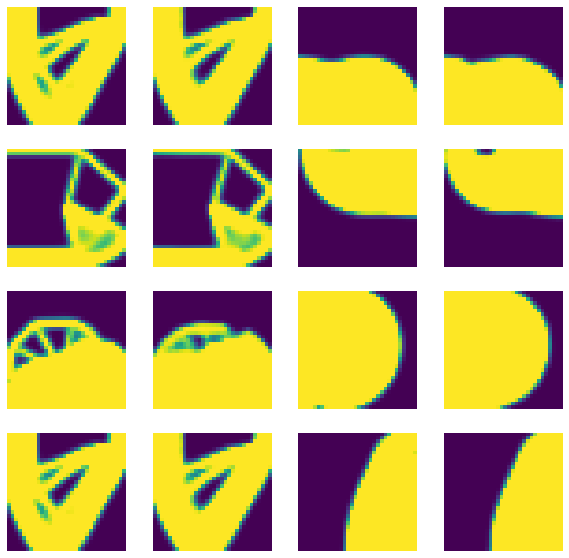

In [21]:
opt_predicted = model.predict(test_data)
fig = plt.figure(figsize =(10,10))
for i in range(8):
    tmp_ind = np.random.randint(low=0,high=test_data.shape[0],size=1)
    sp = fig.add_subplot(4,4,(2*(i+1)-1))
    sp.imshow(test_opt[tmp_ind[0],:,:,0])
    sp.axis('off')
    sp = fig.add_subplot(4,4,(2*(i+1)))
    sp.imshow(opt_predicted[tmp_ind[0],:,:,0])
    sp.axis('off')

(-0.5, 31.5, 31.5, -0.5)

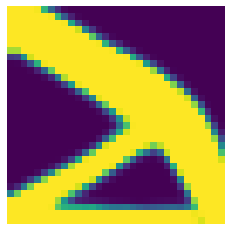

In [9]:
fix_x_test = np.zeros([1,33,33,1])
fix_x_test[0,:,0,0] = 1
fix_y_test = np.zeros([1,33,33,1])
fix_y_test[0,:,0,0] = 1
force_x_test = np.zeros([1,33,33,1])
force_y_test = np.zeros([1,33,33,1])
force_y_test[0,32,32,0] = -1
vf_test = 0.5*np.ones([1,33,33,1])

test_input = np.concatenate((fix_x_test,fix_y_test,force_x_test,force_y_test,vf_test),axis=3)
mbb_predicted = model.predict(test_input)
plt.imshow(mbb_predicted[0,:,:,0])
plt.axis('off')

In [10]:
model.save("ver.2_skip.h5")

In [11]:
model_loaded = tf.keras.models.load_model("ver.2_skip.h5")

(-0.5, 31.5, 31.5, -0.5)

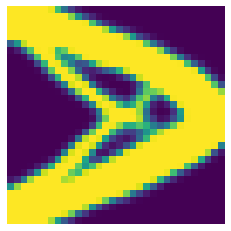

In [12]:
fix_x_load = np.zeros([1,33,33,1])
fix_x_load[0,:,0,0] = 1
fix_y_load = np.zeros([1,33,33,1])
fix_y_load[0,:,0,0] = 1
force_x_load = np.zeros([1,33,33,1])
force_y_load = np.zeros([1,33,33,1])
force_y_load[0,16,32,0] = -1
vf_load = 0.5*np.ones([1,33,33,1])

test_input_load = np.concatenate((fix_x_load,fix_y_load,force_x_load,force_y_load,vf_load),axis=3)
mbb_loaded_predicted = model_loaded.predict(test_input_load)
plt.imshow(mbb_loaded_predicted[0,:,:,0])
plt.axis('off')

In [13]:
model.summary()

Model: "Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 33, 33, 5)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1344        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

Text(0.5, 1.0, 'Training Loss')

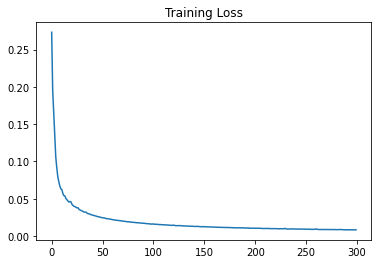

In [14]:
plt.plot(fitting.history['loss'])
plt.title('Training Loss')